In [24]:
!pip install pyngrok
!ngrok config add-authtoken 2kzBTDWP8PMhjmPH4G2n954yNUB_7fUTFVwHrMrBf6yWXo2K2
%pip install Flask
import kagglehub
import warnings
from flask import Flask, jsonify, request
from pyngrok import ngrok
from werkzeug.utils import secure_filename
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
from PIL import Image
warnings.filterwarnings('ignore')

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [10]:
path = kagglehub.dataset_download("aiolapo/jaundice-image-data")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/jaundice-image-data


In [12]:
!mv /kaggle/input/jaundice-image-data data

mv: cannot remove '/kaggle/input/jaundice-image-data/normal/normal (681).jpg': Read-only file system
mv: cannot remove '/kaggle/input/jaundice-image-data/normal/normal (858).jpg': Read-only file system
mv: cannot remove '/kaggle/input/jaundice-image-data/normal/normal (902).jpg': Read-only file system
mv: cannot remove '/kaggle/input/jaundice-image-data/normal/normal (744).jpg': Read-only file system
mv: cannot remove '/kaggle/input/jaundice-image-data/normal/normal (1094).jpg': Read-only file system
mv: cannot remove '/kaggle/input/jaundice-image-data/normal/normal (862).jpg': Read-only file system
mv: cannot remove '/kaggle/input/jaundice-image-data/normal/normal (1066).jpg': Read-only file system
mv: cannot remove '/kaggle/input/jaundice-image-data/normal/normal (842).jpg': Read-only file system
mv: cannot remove '/kaggle/input/jaundice-image-data/normal/normal (716).jpg': Read-only file system
mv: cannot remove '/kaggle/input/jaundice-image-data/normal/normal (1043).jpg': Read-only

In [13]:
import numpy as np
import cv2
import os

def load_images(jaundice_dir, normal_dir):
    images = []
    labels = []

    # Initialize directory and labels
    directories = [(jaundice_dir, 'Jaundice'), (normal_dir, 'Normal')]

    index = 0
    while index < len(directories):
        dir_path, label = directories[index]
        filenames = os.listdir(dir_path)

        if not filenames:
            print(f"No files found in directory: {dir_path}")

        file_index = 0
        while file_index < len(filenames):
            filename = filenames[file_index]
            img_path = os.path.join(dir_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                image = cv2.resize(image, (64, 64))  # Resize to a fixed size
                images.append(image)
                labels.append(label)
            else:
                print(f"Failed to read image: {img_path}")

            file_index += 1

        index += 1

    if not images:
        print("No images were loaded.")

    images = np.array(images)
    labels = np.array(labels)

    print(f"Loaded {len(images)} images with labels.")

    return images, labels


jaundice_dir = '/kaggle/input/jaundice-image-data/jaundice'
normal_dir = '/kaggle/input/jaundice-image-data/normal'

# Load images
images, labels = load_images(jaundice_dir, normal_dir)

# Flatten images for XGBoost
if len(images) > 0:
    n_samples = images.shape[0]
    images_flattened = images.reshape(n_samples, -1)
    print(f"Images flattened to shape: {images_flattened.shape}")
else:
    print("No images to flatten.")

Loaded 760 images with labels.
Images flattened to shape: (760, 4096)


Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.90      0.84       115
    Jaundice       0.42      0.22      0.29        37

    accuracy                           0.74       152
   macro avg       0.60      0.56      0.56       152
weighted avg       0.69      0.74      0.70       152



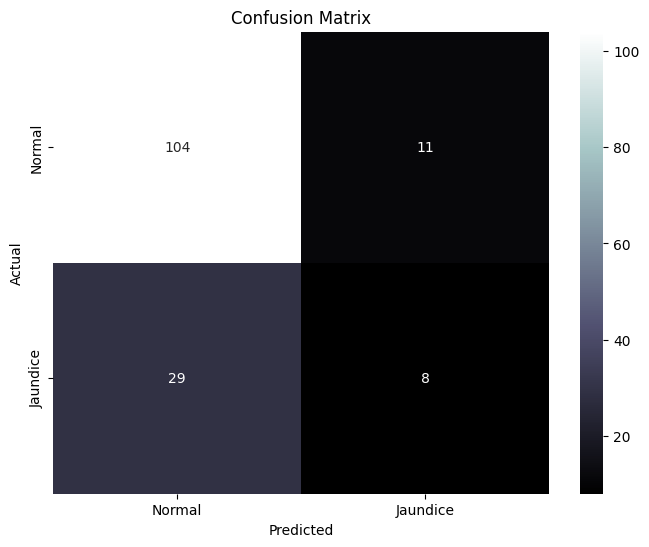

In [14]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure images are flattened and labels are encoded
def encode_labels(labels):
    return np.where(labels == 'Jaundice', 1, 0)

# Encode labels
encoded_labels = encode_labels(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_flattened, encoded_labels, test_size=0.2, random_state=42)

# Initialize the XGBoost model
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgboost_model.fit(X_train, y_train)

# Make predictions
y_pred = xgboost_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Jaundice']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='bone', xticklabels=['Normal', 'Jaundice'], yticklabels=['Normal', 'Jaundice'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.90      0.84       115
    Jaundice       0.42      0.22      0.29        37

    accuracy                           0.74       152
   macro avg       0.60      0.56      0.56       152
weighted avg       0.69      0.74      0.70       152



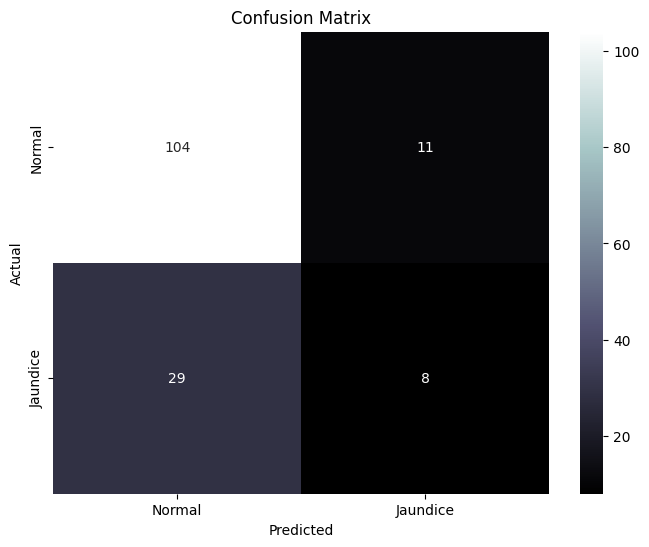

In [16]:

# Make predictions
y_pred = xgboost_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Jaundice']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='bone', xticklabels=['Normal', 'Jaundice'], yticklabels=['Normal', 'Jaundice'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Top features:
      Feature  Importance
472       472    0.021562
516       516    0.018284
8           8    0.017224
1051     1051    0.016311
3018     3018    0.014951
1699     1699    0.014692
2951     2951    0.014655
2312     2312    0.013586
2701     2701    0.012899
1856     1856    0.012655


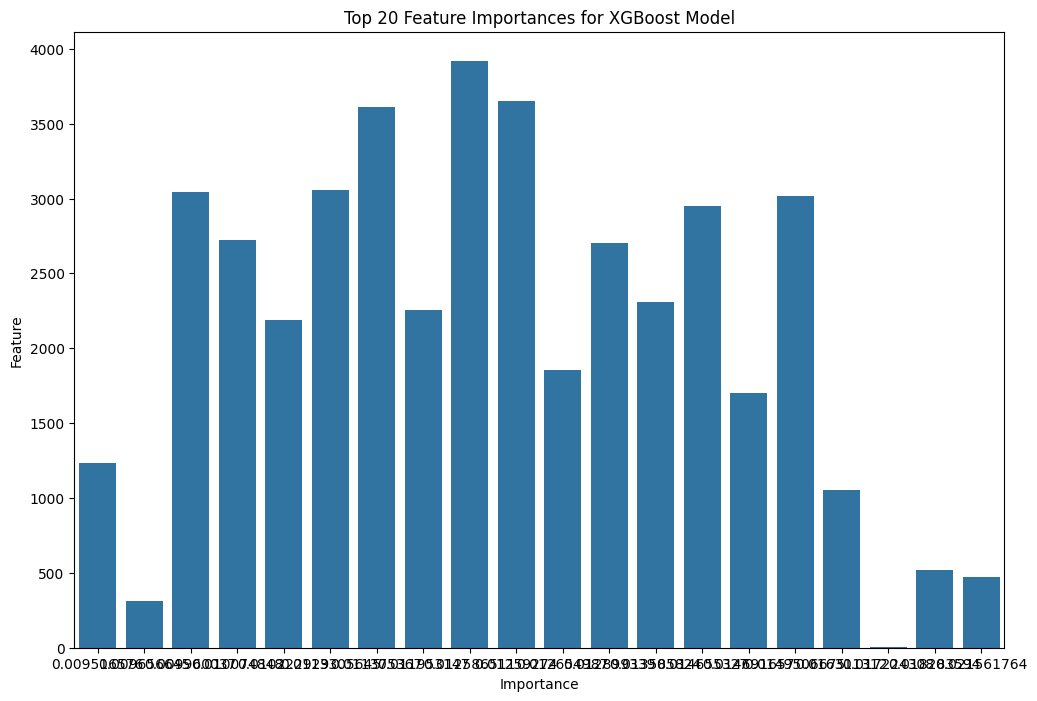

In [17]:
# Feature Importance
importances = xgboost_model.feature_importances_

# Create a DataFrame for better visualization
import pandas as pd
import numpy as np

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': np.arange(images_flattened.shape[1]),
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print top features
print("Top features:")
print(feature_importance_df.head(10))

# Plot Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.90      0.84       115
    Jaundice       0.42      0.22      0.29        37

    accuracy                           0.74       152
   macro avg       0.60      0.56      0.56       152
weighted avg       0.69      0.74      0.70       152



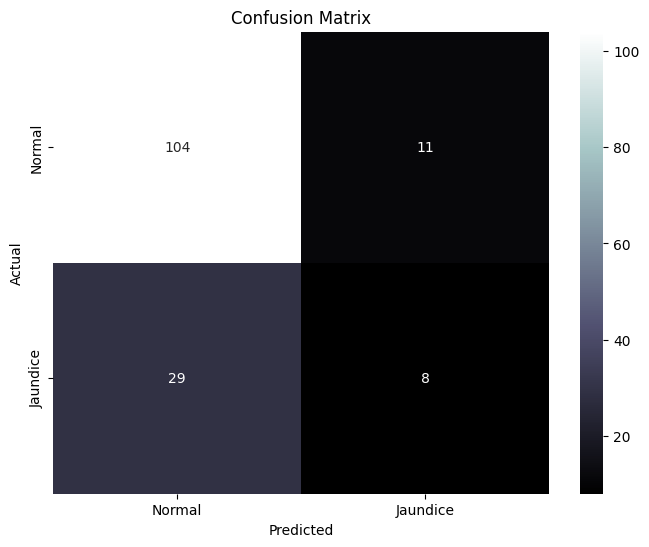

Top features:
      Feature  Importance
472       472    0.021562
516       516    0.018284
8           8    0.017224
1051     1051    0.016311
3018     3018    0.014951
1699     1699    0.014692
2951     2951    0.014655
2312     2312    0.013586
2701     2701    0.012899
1856     1856    0.012655


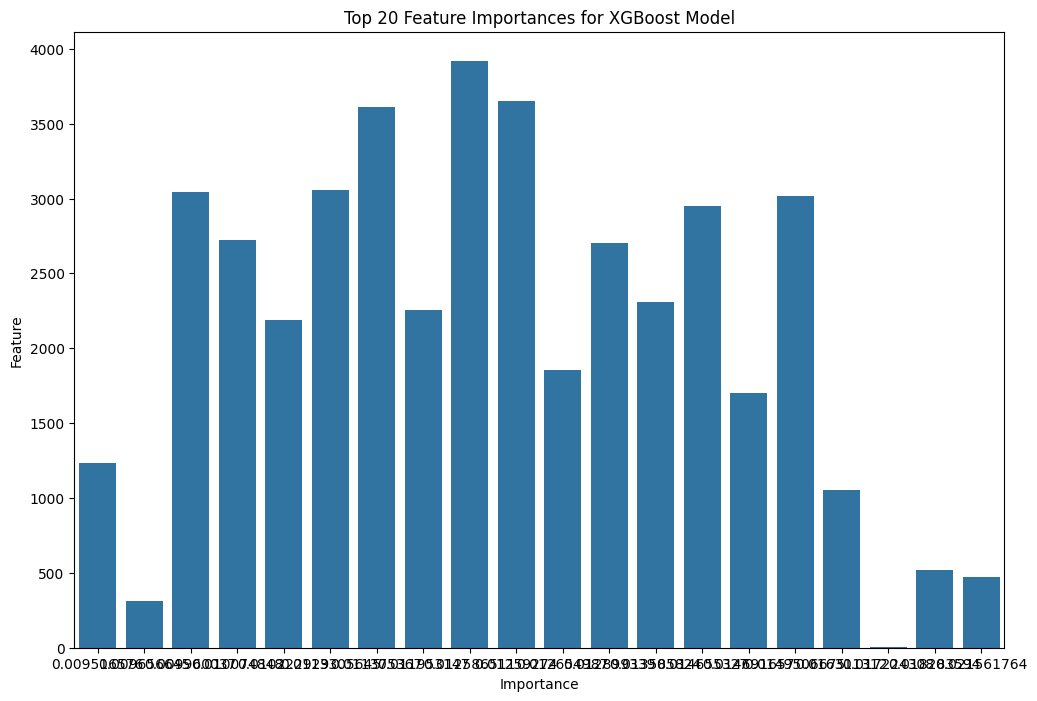

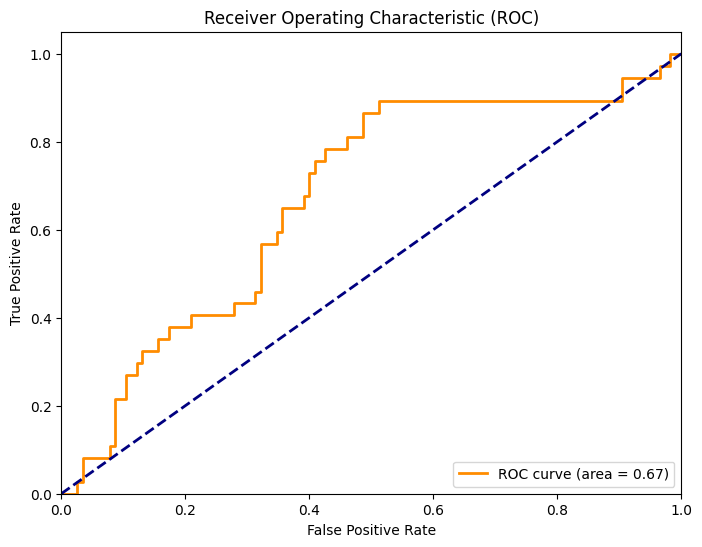

In [18]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure images are flattened and labels are encoded
def encode_labels(labels):
    return np.where(labels == 'Jaundice', 1, 0)

# Encode labels
encoded_labels = encode_labels(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_flattened, encoded_labels, test_size=0.2, random_state=42)

# Initialize the XGBoost model
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgboost_model.fit(X_train, y_train)

# Make predictions
y_pred = xgboost_model.predict(X_test)
y_prob = xgboost_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Jaundice']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='bone', xticklabels=['Normal', 'Jaundice'], yticklabels=['Normal', 'Jaundice'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
importances = xgboost_model.feature_importances_

# Create a DataFrame for better visualization
import pandas as pd

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': np.arange(images_flattened.shape[1]),
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print top features
print("Top features:")
print(feature_importance_df.head(10))

# Plot Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# ROC Curve Analysis
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [49]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L') # Convert to grayscale
    img = img.resize((64, 64)) # Resize to 64x64
    img_array = np.array(img)
    img_array = img_array.flatten() # Flatten the image
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    return img_array

In [57]:
app = Flask(__name__)
@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({'status': 'healthy'}), 200

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part in the request'}), 400

    file = request.files['file']

    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400

    if file:
        filename = secure_filename(file.filename)
        temp_filepath = os.path.join('/tmp', filename)
        file.save(temp_filepath)

        try:
            preprocessed_img = preprocess_image(temp_filepath)

            prediction = xgboost_model.predict(preprocessed_img)

            # Access the prediction result correctly
            print(prediction.flatten()[0])
            predicted_class = 'jaundice' if prediction.flatten()[0] == 1 else 'normal'


            return jsonify({'prediction': predicted_class})

        except Exception as e:
            return jsonify({'error': str(e)}), 500
        finally:
            # Remove the temporary file
            if os.path.exists(temp_filepath):
                os.remove(temp_filepath)
    else:
        return jsonify({'error': 'Something went wrong with the file upload'}), 500

In [58]:
# # prompt: predict this image: "/kaggle/input/jaundice-image-data/jaundice/jaundice (104).jpg"

# image_to_predict_path = "/kaggle/input/jaundice-image-data/normal/normal (1077).jpg"
# preprocessed_single_image = preprocess_image(image_to_predict_path)
# prediction_single_image = xgboost_model.predict(preprocessed_single_image)
# print("sdfklajsdf;dsjkf: "+ str(prediction_single_image))
# predicted_class_single_image = 'jaundice' if prediction_single_image.flatten()[0] == 1 else 'normal'
# print(f"The predicted class for the image is: {predicted_class_single_image}")

In [ ]:
port = 5000
public_url = ngrok.connect(port).public_url
print(' * ngrok tunnel "{}" -> "http://127.0.0.1:{}"'.format(public_url, port))
app.run(host='0.0.0.0', port=port)

 * ngrok tunnel "https://112dac6022d0.ngrok-free.app" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Jul/2025 19:34:02] "GET /health HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jul/2025 19:34:09] "POST /predict HTTP/1.1" 200 -


0


INFO:werkzeug:127.0.0.1 - - [21/Jul/2025 19:34:20] "POST /predict HTTP/1.1" 200 -


1


INFO:werkzeug:127.0.0.1 - - [21/Jul/2025 19:34:40] "GET /health HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jul/2025 19:34:45] "POST /predict HTTP/1.1" 200 -


0


INFO:werkzeug:127.0.0.1 - - [21/Jul/2025 19:34:53] "GET /health HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jul/2025 19:34:58] "POST /predict HTTP/1.1" 200 -


0


INFO:werkzeug:127.0.0.1 - - [21/Jul/2025 19:35:16] "POST /predict HTTP/1.1" 200 -


1
